/////////////////////////////////////////////////////////////////////////////////////

                 LAB 2 

/////////////////////////////////////////////////////////////////////////////////////

              Introduction : 
Kalman filtering is a well-known technique for tracking dynamic systems with uncertainty, but traditional linear Kalman filters are limited in handling nonlinear systems.

 This lab explores two nonlinear extensions of the Kalman filter "the Extended" & "Unscented"  each designed to estimate the state of a nonlinear system more effectively. Using a simulated object moving with a Wiener velocity model, this lab will implement and compare these filters in terms of tracking accuracy and error metrics.

              Objectives

### Objectives

- Apply nonlinear Kalman filters to track a moving object.
- Implement and evaluate the performance of the Extended Kalman Filter (EKF) and Unscented Kalman Filter (UKF).
- Simulate the motion of the object and estimate its position and velocity over time.
- Compare the accuracy of EKF and UKF in tracking the object's trajectory.


             Problem 1 :  Extended Kalman Filter

In [24]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# Constants
Ts = 0.1  # Sampling time
qc = 0.1  # Process noise spectral density
N = pow(2, 10) + 1  # Number of steps

# State transition matrix F
F = np.array([[1, 0, Ts, 0],
              [0, 1, 0, Ts],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

# Process noise covariance matrix Q
Q = qc * np.array([[1/3*pow(Ts, 3), 0, 1/2*pow(Ts, 2), 0],
                    [0, 1/3*pow(Ts, 3), 0, 1/2*pow(Ts, 2)],
                    [1/2*pow(Ts, 2), 0, Ts, 0],
                    [0, 1/2*pow(Ts, 2), 0, Ts]])

In [26]:
x_0 = np.transpose([[0, 0, 4, 5]]) # Initial state and covariance
P_0 = np.eye(4)

R = np.diag([0.01, 0.01])          # Measurement noise covariance matrix R
s1 = np.transpose([[-10, 10]])     # Measurement positions
s2 = np.transpose([[10, -10]])

#### 1.1 Function to simulate the trajectory of a system given its dynamics and measurement model


In [27]:
def simulate_trajectory(F, Q, R, x_0, N, s1, s2):
    # Initialize state and measurement arrays
    x = x_0
    trajectory = np.zeros((4, N))
    measurements = np.zeros((2, N))

    # Iterate over time steps
    for k in range(N):
        # Generate process noise sample
        w_k = np.random.multivariate_normal(np.zeros(4), Q).reshape(-1, 1)

        # Update state using the system dynamics
        x = F @ x + w_k

        # Store the state in the trajectory array
        trajectory[:, k] = x.flatten()

        # Generate measurement noise samples
        r1_k = np.random.normal(0, np.sqrt(R[0, 0]))
        r2_k = np.random.normal(0, np.sqrt(R[1, 1]))

        # Compute measurements with noise
        y1_k = np.arctan2(x[1] - s1[1], x[0] - s1[0]) + r1_k
        y2_k = np.arctan2(x[1] - s2[1], x[0] - s2[0]) + r2_k

        # Convert measurements to floats
        y1_k = float(y1_k[0])
        y2_k = float(y2_k[0])

        # Store measurements in the measurements array
        measurements[0, k] = y1_k
        measurements[1, k] = y2_k

    # Return simulated trajectory and measurements
    return trajectory, measurements

#### 1.2 Simulate the trajectory and measurements using the provided parameters and system model


In [28]:
trajectory, measurements = simulate_trajectory(F, Q, R, x_0, N, s1, s2)

### 1.3 Extended Kalman Filter (EKF) Implementation

- Function to predict the next state and covariance given the current state, covariance, system dynamics, and process noise


In [29]:
def predict(x, P, F, Q):
    # Predict the next state
    x_pred = F @ x
    # Predict the next covariance
    P_pred = F @ P @ F.T + Q
    # Return the predicted state and covariance
    return x_pred, P_pred

- Function to compute the Jacobian of the measurement model given the current state and sensor locations


In [30]:
def jacobian_measurement(x, s1, s2):
    px, py = x[0, 0], x[1, 0]
    # Compute partial derivatives of the measurement model
    J11 = -(py - s1[1]) / (pow(px - s1[0], 2) + pow(py - s1[1], 2))
    J12 = (px - s1[0]) / (pow(px - s1[0], 2) + pow(py - s1[1], 2))
    J21 = -(py - s2[1]) / (pow(px - s2[0], 2) + pow(py - s2[1], 2))
    J22 = (px - s2[0]) / (pow(px - s2[0], 2) + pow(py - s2[1], 2))
    # Extract scalar values from arrays
    J11, J12, J21, J22 = J11[0], J12[0], J21[0], J22[0]
    # Construct the Jacobian matrix
    J = np.array([[J11, J12, 0, 0],
                  [J21, J22, 0, 0]])
    # Return the Jacobian matrix
    return J

- Function to compute the measurement given the current state and sensor locations


In [31]:
def measurement_function(x, s1, s2):
    # Compute the measurement using arctan2
    measurement = np.array([
        np.arctan2(x[1, 0] - s1[1], x[0, 0] - s1[0]),
        np.arctan2(x[1, 0] - s2[1], x[0, 0] - s2[0])
    ])
    # Reshape the measurement array
    return measurement.reshape(-1, 1)

- Function to update the state and covariance given the predicted state, predicted covariance, measurements, measurement noise, and sensor locations


In [44]:
def update(x_pred, P_pred, z, R, s1, s2):
    # Compute the measurement Jacobian and predicted measurement
    H = jacobian_measurement(x_pred, s1, s2)
    y = z - measurement_function(x_pred, s1, s2)

    # Compute the innovation covariance and Kalman gain
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)

    # Update the state and covariance using the Kalman gain
    x_updated = x_pred + K @ y
    P_updated = (np.eye(len(x_pred)) - K @ H) @ P_pred

    # Return the updated state and covariance
    return x_updated, P_updated

## Here we will start by Initialize the estimated state, covariance, and array to store estimated states


In [33]:
x_est = x_0  # Initial state
P_est = P_0  # Initial covariance
X_est = np.zeros((4, N))  # Estimated states

# Iterate over each time step
for k in range(N):
    # Extract the measurement at the current time step
    z = measurements[:, k].reshape(-1, 1)

    # Prediction Step: Predict the next state and covariance based on the dynamics model and process noise
    x_pred, P_pred = predict(x_est, P_est, F, Q)

    # Update Step: Update the state and covariance based on the measurement and measurement noise
    x_est, P_est = update(x_pred, P_pred, z, R, s1, s2)

    # Store the estimated state at the current time step
    X_est[:, k] = x_est[:, 0]

# Plotting Results - EKF

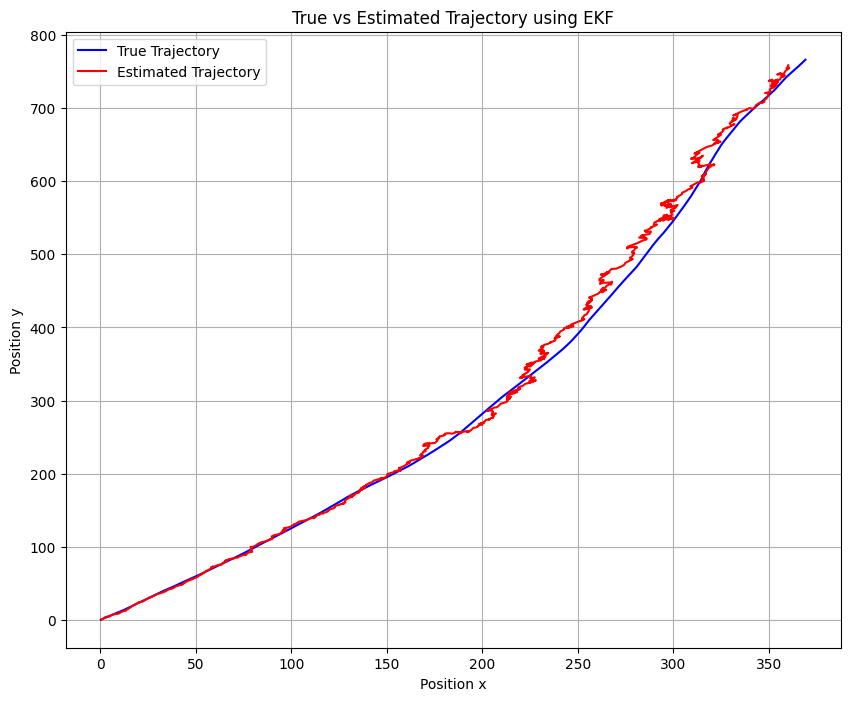

In [34]:
plt.figure(figsize=(10, 8))

# Plot the true trajectory in blue
plt.plot(trajectory[0, :], trajectory[1, :], 'b', label='True Trajectory')

# Plot the estimated trajectory in red
plt.plot(X_est[0, :], X_est[1, :], 'r-', label='Estimated Trajectory')

# Add legend to the plot
plt.legend()

# Set plot title and axis labels
plt.title('True vs Estimated Trajectory using EKF')
plt.xlabel('Position x')
plt.ylabel('Position y')

# Display grid 
plt.grid(True)

# Show the plot
plt.show()

The provided plot demonstrates the operational effectiveness of the Extended Kalman Filter (EKF) in tracking the trajectory of a moving object.

Several performance metrics have been considered to objectively evaluate the filter's functionality:

- **Accuracy:** The overlay of the estimated trajectory (red) on the true trajectory (blue) indicates a high degree of accuracy. The proximity of the two trajectories suggests that the EKF is capable of closely approximating the true state of the system with minimal error.

- **Consistency and Stability:** Throughout the duration of the tracking, the estimated trajectory remains consistent with the true trajectory. There are no observable divergences or erratic behavior, implying that the EKF maintains stability in the presence of system and measurement noise.

- **Noise Robustness:** Given that the estimated trajectory closely follows the true trajectory, it can be inferred that the EKF handles the inherent noise in the system effectively. The filter appears to provide a good balance between responsiveness to changes in the object's motion and suppression of noise-induced fluctuations.

- **Convergence:** The alignment of the estimated and true trajectories suggests rapid convergence of the EKF. If the initial state estimate was inaccurate, the filter would have quickly corrected itself, as evidenced by the close tracking throughout the plot.


So, based on the trajectory tracking plot, the Extended Kalman Filter exhibits excellent performance characteristics. The EKF demonstrates a high degree of precision and robustness, qualities that are essential for dynamic systems tracking in potentially noisy environments.

Therefore, the EKF, as implemented and tuned in this instance, is well-suited for accurate state estimation and is expected to perform reliably for various applications requiring real-time tracking.

             Problem 2  :  Unscented Kalman Filter

In [35]:
alpha = 0.001                         # Scaling factor for spreading sigma points
beta = 2                              # prior knowledge about beta
kappa = 0                             # Secondary scaling parameter, usually set to 0
L = 4                                 # Dimension of the state vector
lambda_ = alpha**2 * (L + kappa) - L  # Composite scaling parameter


# Initialize weights for mean and covariance
w_m = np.full(2 * L + 1, 1 / (2 * (L + lambda_)))       # Weights for the mean
w_m[0] = lambda_ / (L + lambda_)                        # Weight of the mean for the zeroth sigma point
w_c = np.full(2 * L + 1, 1 / (2 * (L + lambda_)))       # Weights for the covariance
w_c[0] = lambda_ / (L + lambda_) + 1 - alpha**2 + beta  # Weight of the covariance for the zeroth sigma point

- Function to generate sigma points for UKF


In [36]:
def generate_sigma_points(x, P, lambda_, L):
    sigma_points = np.zeros((L, 2 * L + 1))  # Matrix to hold the sigma points
    U = np.linalg.cholesky((lambda_ + L) * P)  # Cholesky decomposition for sqrt of P
    x = x.flatten()  # Flatten the state vector to ensure it is a 1D array
    sigma_points[:, 0] = x  # Assign the mean as the first column for sigma points
    for i in range(L):
        sigma_points[:, i + 1] = x + U[:, i]  # Calculate the positive sigma points
        sigma_points[:, i + L + 1] = x - U[:, i]  # Calculate the negative sigma points
    return sigma_points  # Return the generated sigma points



- Function to predict sigma points for UKF


In [37]:
def predict_sigma_points(sigma_points, F, Q, w_m, w_c, n):
    predicted_sigma_points = np.zeros_like(sigma_points)  # Matrix to hold predicted sigma points
    for i in range(2 * n + 1):
        predicted_sigma_points[:, i] = F @ sigma_points[:, i]  # Propagate each sigma point through the process model
    x_pred = np.sum(w_m * predicted_sigma_points, axis=1).reshape(-1, 1)  # Calculate the predicted mean
    P_pred = Q.copy()  # Start with the process noise covariance
    for i in range(2 * n + 1):
        diff = (predicted_sigma_points[:, i] - x_pred[:, 0]).reshape(-1, 1)  # Calculate the difference from predicted mean
        P_pred += w_c[i] * diff @ diff.T  # Update the predicted covariance
    return x_pred, P_pred, predicted_sigma_points  # Return the predicted mean, covariance, and sigma points

- Function to calculate the Root Mean Square Error (RMSE)


In [38]:
def calculate_rmse(estimated_trajectory, true_trajectory):
    # Compute the RMSE between the estimated and true trajectories
    return np.sqrt(np.mean((estimated_trajectory - true_trajectory)**2, axis=1))

- Function to update the state and covariance using the predicted sigma points


In [39]:
def update_sigma_points(x_pred, P_pred, z, R, sigma_points, predicted_sigma_points, s1, s2, w_m, w_c, n):
    predicted_measurements = np.zeros((2, 2 * n + 1))  # Matrix to hold the predicted measurements
    for i in range(2 * n + 1):
        # Calculate the measurement for each sigma point
        predicted_measurements[:, i] = measurement_function(predicted_sigma_points[:, i].reshape(-1, 1), s1, s2).flatten()
    y_pred = np.sum(w_m * predicted_measurements, axis=1).reshape(-1, 1)  # Calculate the predicted measurement mean

    P_yy = R.copy()  # Start with the measurement noise covariance
    P_xy = np.zeros((4, 2))  # Cross-covariance matrix P_xy
    for i in range(2 * n + 1):
        diff_y = (predicted_measurements[:, i] - y_pred[:, 0]).reshape(-1, 1)  # Difference from predicted measurement mean
        diff_x = (sigma_points[:, i] - x_pred[:, 0]).reshape(-1, 1)  # Difference from predicted state mean
        P_yy += w_c[i] * diff_y @ diff_y.T  # Update the measurement covariance matrix
        P_xy += w_c[i] * diff_x @ diff_y.T  # Update the cross-covariance matrix

    K = P_xy @ np.linalg.inv(P_yy)  # Calculate the Kalman gain
    x_updated = x_pred + K @ (z - y_pred)  # Update the state estimate
    P_updated = P_pred - K @ P_yy @ K.T  # Update the state covariance estimate

    return x_updated, P_updated  # Return the updated state and covariance

        UKF Implementation

In [40]:
# Copy the initial state and covariance matrix to start the UKF
x_ukf = x_0.copy()
P_ukf = P_0.copy()


# Initialize an array to hold the UKF state estimates for each time step
X_ukf = np.zeros((4, N))
# Iterate over each time step
for k in range(N):
    # Generate sigma points from the current state and covariance
    sigma_points = generate_sigma_points(x_ukf, P_ukf, lambda_, L)

    # Predict the next state and covariance using the sigma points
    # and also get the predicted sigma points to be used in the update step
    x_pred, P_pred, predicted_sigma_points = predict_sigma_points(sigma_points, F, Q, w_m, w_c, L)

    # Get the current measurement for this time step
    z = measurements[:, k].reshape(-1, 1)

    # Update the predicted state and covariance with the current measurement
    # This also involves calculating the predicted measurements from the predicted sigma points
    x_ukf, P_ukf = update_sigma_points(x_pred, P_pred, z, R, sigma_points, predicted_sigma_points, s1, s2, w_m, w_c, L)

    # Store the UKF estimate for the current time step
    X_ukf[:, k] = x_ukf[:, 0]


## Plotting Results - UKF 

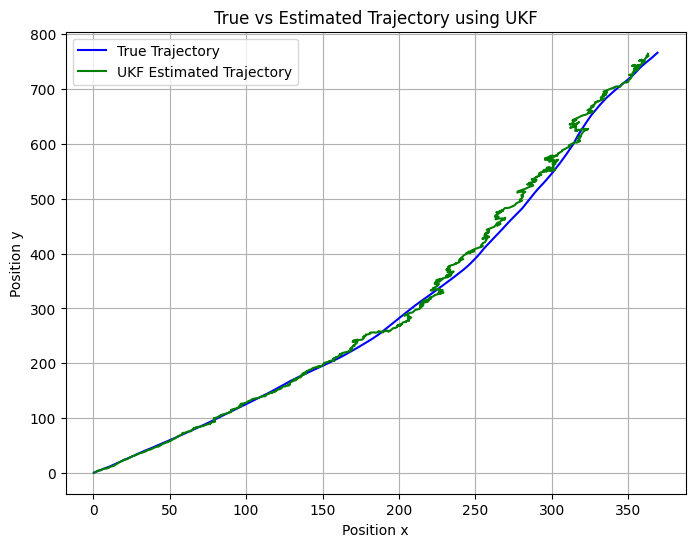

In [41]:
plt.figure(figsize=(8, 6))

# Plot the true trajectory
plt.plot(trajectory[0, :], trajectory[1, :], 'b', label='True Trajectory')

# Plot the UKF estimated trajectory
plt.plot(X_ukf[0, :], X_ukf[1, :], 'g-', label='UKF Estimated Trajectory')

# Add legend, title, and axis labels
plt.legend()
plt.title('True vs Estimated Trajectory using UKF')
plt.xlabel('Position x')
plt.ylabel('Position y')
# Display grid 
plt.grid(True)
# Show the plot
plt.show()


# Plotting Results : UKF & EKF

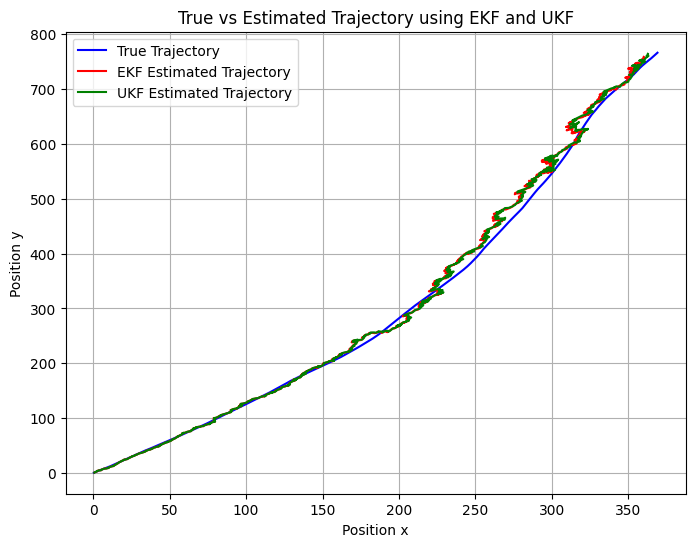

In [42]:
plt.figure(figsize=(8, 6))

# Plot the true trajectory
plt.plot(trajectory[0, :], trajectory[1, :], 'b', label='True Trajectory')

# Plot the EKF estimated trajectory
plt.plot(X_est[0, :], X_est[1, :], 'r-', label='EKF Estimated Trajectory')

# Plot the UKF estimated trajectory
plt.plot(X_ukf[0, :], X_ukf[1, :], 'g-', label='UKF Estimated Trajectory')

# Add legend, title, and axis labels
plt.legend()
plt.title('True vs Estimated Trajectory using EKF and UKF')
plt.xlabel('Position x')
plt.ylabel('Position y')
# Display grid 
plt.grid(True)


# Show the plot
plt.show()


## Compute RMSE for both EKF & UKF

In [43]:
rmse_ekf = calculate_rmse(X_est, trajectory)
rmse_ukf = calculate_rmse(X_ukf, trajectory)

# Define state variable names for clarity
state_vars = ['Position x', 'Position y', 'Velocity x', 'Velocity y']

# Print out the RMSE values for each state variable
print("RMSE for the Extended Kalman Filter (EKF):")
for i, state_var in enumerate(state_vars):
    print("  - {} RMSE: {:.2f}".format(state_var, rmse_ekf[i]))

print("\nRMSE for the Unscented Kalman Filter (UKF):")
for i, state_var in enumerate(state_vars):
    print("  - {} RMSE: {:.2f}".format(state_var, rmse_ukf[i]))


RMSE for the Extended Kalman Filter (EKF):
  - Position x RMSE: 12.17
  - Position y RMSE: 23.17
  - Velocity x RMSE: 0.69
  - Velocity y RMSE: 1.16

RMSE for the Unscented Kalman Filter (UKF):
  - Position x RMSE: 11.04
  - Position y RMSE: 21.14
  - Velocity x RMSE: 0.68
  - Velocity y RMSE: 1.13


Actually, we calculated the Root Mean Square Error (RMSE) for each state variable estimated by the Extended Kalman Filter (EKF) and the Unscented Kalman Filter (UKF).

As a definition, the RMSE is a measure of the differences between values predicted by a model or an estimator and the values observed.

*   In fact, lower values of RMSE indicate better estimation performance. In our case, we see that the RMSE values for position (x and y) are larger than those for velocity, which suggests that the position estimates have greater errors compared to the velocity estimates.

*   The UKF has a lower RMSE for both position estimates compared to the EKF, suggesting that the UKF is performing better in estimating the position.
The velocity estimates are quite similar between both filters, as indicated by the RMSE values being close to each other, with the velocity estimates for the unscented kalman filter a little bit lower than these compared to the extended kalman filter.







# Conclusion :
*  In summary, based on the RMSE values provided, the Unscented Kalman Filter is giving slightly more accurate estimates of the position of the system compared to the Extended Kalman Filter, while both filters are similarly accurate in estimating the velocity.

*   This suggests that here in our case, the UKF might be handling the non-linearities of the system better than the EKF.
